# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$ 
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ 
$$ y_{i} \in \{-1, 1\}$$ 
where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1 / (1 + np.exp(-X.dot(weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        logLoss = np.mean(np.log(1 + np.exp(-(x.dot(weights) * y))))
        penalty = (1 / (2 * self.C)) * np.sum(weights ** 2)
        return logLoss + penalty
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        loss_history = []
        loss_history.append(self.get_loss(X_ext, self.weights_, y))

        for i in range(self.max_iter):
            # delta = -np.mean((y * X_ext.T * (1 - (1 / (1 + np.exp(-(X_ext.dot(self.weights_)) * y))))), axis=1) + (1 / self.C) * self.weights_
            delta_first_term = 0
            for i in range(y.shape[0]):
                delta_first_term += y[i] * X_ext[i] * (1 - 1 / (1 + np.exp(-(X_ext[i].dot(self.weights_) * y[i]))))
            delta_first_term /= y.shape[0]

            delta = -delta_first_term + (1 / self.C) * self.weights_
            weights_old = self.weights_.copy()
            self.weights_ -= self.eta * delta
            loss_history.append(self.get_loss(X_ext, self.weights_, y))
            l2_norm = np.sqrt(np.sum((self.weights_ - weights_old) ** 2))
            if l2_norm < self.tol:
                break
        
        return loss_history
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [6]:
from sklearn import datasets
from sklearn import metrics

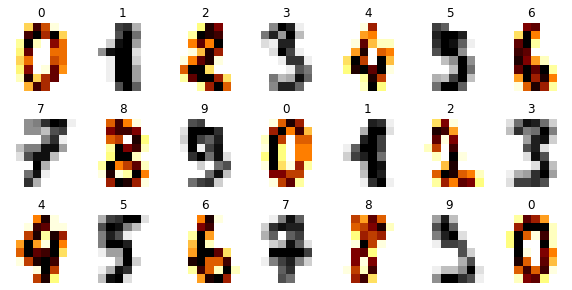

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train);

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

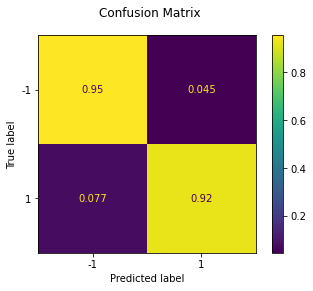

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [18]:
def plot_loss(loss_history, parameters, parameter_name, title):
    plt.figure(figsize=(9, 4.5))
    for i in range(len(parameters)):
        plt.plot(loss_history[i], label=f'{parameter_name}={parameters[i]}')
    plt.xlabel('Iterations')
    plt.ylabel('Loss') 
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

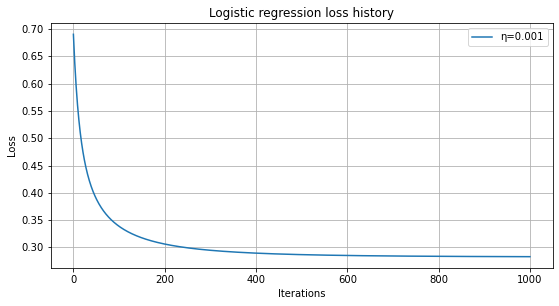

In [19]:
loss_history = []
loss_history.append(model.fit(X_train, y_train))
plot_loss(loss_history, [model.eta], parameter_name='η', title='Logistic regression loss history')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

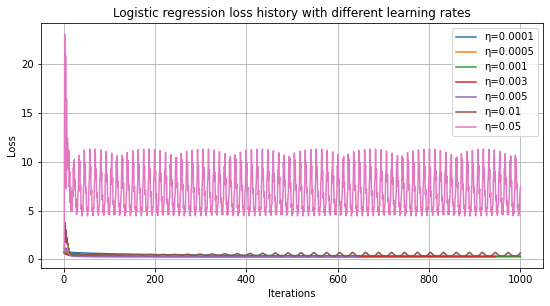

In [20]:
learning_rates = [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.05]

loss_history = []
for eta in learning_rates:
    model = CustomLogisticRegression(eta=eta)
    loss_history.append(model.fit(X_train, y_train))

plot_loss(loss_history, learning_rates, parameter_name='η', title='Logistic regression loss history with different learning rates')

We see strong fluctuations for high learning rate values (0.01 and 0.05). Let's have a closer look to smaller values:

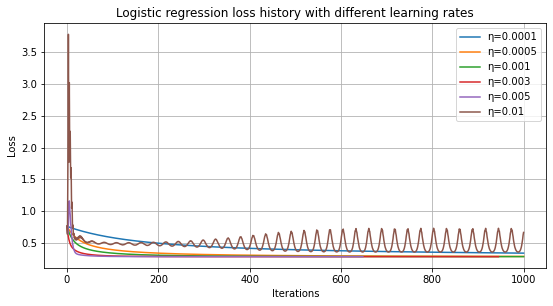

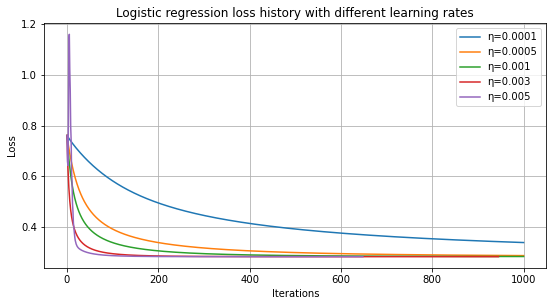

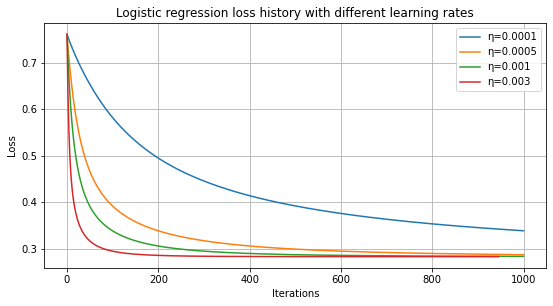

In [21]:
plot_loss(loss_history[:-1], learning_rates[:-1], parameter_name='η', title='Logistic regression loss history with different learning rates')
plot_loss(loss_history[:-2], learning_rates[:-2], parameter_name='η', title='Logistic regression loss history with different learning rates')
plot_loss(loss_history[:-3], learning_rates[:-3], parameter_name='η', title='Logistic regression loss history with different learning rates')

Gradient descent is an iterative algorithm that is used to find the values of model's weights that minimize a cost function as much as possible.  
Learning rate determines how fast or slow we will move towards the optimal weights.  
As we can see on our graphs when learning rate is too small (0.0001) it can't converge in given number of iterations and we need to increase max_iter.  
With higher learning rate values algorithm is able to converge in given amount of iterations and even quicker (for 0.003).  
But when learning rate is too large (0.05, 0.01) gradient descent starts to fluctuate up and down and can just "jump over" the optimal point and will not be able to converge in given number of iterations or never converge at all.  
Thus, it is very important to choose a reasonable learning rate.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [22]:
def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, label='Validation')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend()      
    plt.show()

I will change fit_evaluate() function a little so that it returns the loss as well:

In [23]:
def fit_evaluate_modified(clf, X_train, y_train, X_test, y_test):
    loss = clf.fit(X_train, y_train)
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), \
           loss

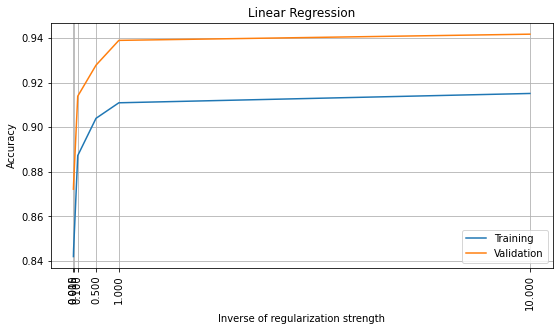

In [24]:
C = [0.005, 0.01, 0.1, 0.5, 1.0, 10.0]
train_accuracy, test_accuracy = [], []
loss_history = []

for inverse_regularization_strength in C:
    model = CustomLogisticRegression(C=inverse_regularization_strength)
    train_acc, test_acc, loss = fit_evaluate_modified(model, X_train, y_train, X_test, y_test)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    loss_history.append(loss)

plot_fitting_graph(C, train_accuracy, test_accuracy, xlabel='Inverse of regularization strength', ylabel='Accuracy', title='Linear Regression')

We see that accuracy is worse for smaller values of C for both training and validation sets. Smaller values specify stronger regularization, in our case C = 0.005 corresponds to λ = 100 and C = 10 corresponds to λ = 0.05. Small C (big λ) penalize our weights too much, that's why we get worse accuracy.  
Let's have a look at loss history:

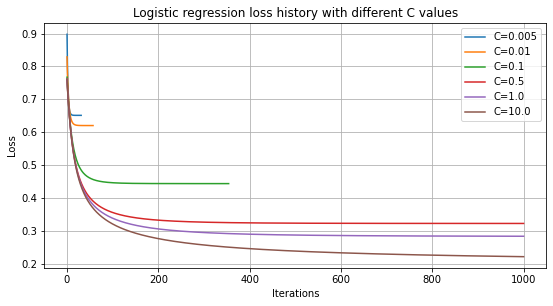

In [25]:
plot_loss(loss_history, C, parameter_name='C', title='Logistic regression loss history with different C values')

Indeed, we see that with small C values (big λ) our model converges too fast. It happens because weights are penalized too much, they get small values and difference between them on gradient descent steps gets very small too, which leads to the execution of stopping criteria $||w^{(t+1)} - w^{(t)}||_2 < tol$.  
It leads to bad loss value, as well as bad accuracy values on train and validation sets (sign of underfitting).  
After C = 10 we don't see any significant changes in model quality (λ approaches to zero and, roughly speaking, doesn't contribute a lot to weights penalizing).  
Thus, it is very important to choose C value properly.

**(0.5 points)** Compare zero initialization and random initialization. 

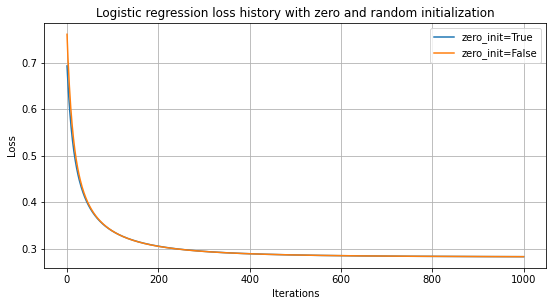

In [26]:
loss_history = []
model = CustomLogisticRegression(zero_init=True)
loss_history.append(model.fit(X_train, y_train))
model = CustomLogisticRegression(zero_init=False)
loss_history.append(model.fit(X_train, y_train))

plot_loss(loss_history, [True, False], 'zero_init', title='Logistic regression loss history with zero and random initialization')

Initial loss for model with zero initialization is slightly less, but there is no any significant difference between two cases.   
But let's have a look at random weight initialization in our class:
```
weight_threshold = 1.0 / (2 * num_features)  
self.weights_ = self.random_state.uniform(low=-weight_threshold, high=weight_threshold, size=num_features)
```

In [27]:
weight_threshold = 1.0 / (2 * 65)  
print(f'weights range: [{-weight_threshold}, {weight_threshold})')

weights range: [-0.007692307692307693, 0.007692307692307693)


We see that weights are generated in a very small (close to zero) range. To get a clearer sense what affect random initialization could have let's redefine our class so that it will generate weights from bigger range:

In [28]:
class CustomLogisticRegressionWithBiggerRandomWeightsRange(CustomLogisticRegression):
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            # set bigger threshold
            weight_threshold = 5
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        loss_history = []
        loss_history.append(self.get_loss(X_ext, self.weights_, y))

        for i in range(self.max_iter):
            delta_first_term = 0
            for i in range(y.shape[0]):
                delta_first_term += y[i] * X_ext[i] * (1 - 1 / (1 + np.exp(-(X_ext[i].dot(self.weights_) * y[i]))))
            delta_first_term /= y.shape[0]

            delta = -delta_first_term + (1 / self.C) * self.weights_
            weights_old = self.weights_.copy()
            self.weights_ -= self.eta * delta
            loss_history.append(self.get_loss(X_ext, self.weights_, y))
            l2_norm = np.sqrt(np.sum((self.weights_ - weights_old) ** 2))
            if l2_norm < self.tol:
                break
        
        return loss_history

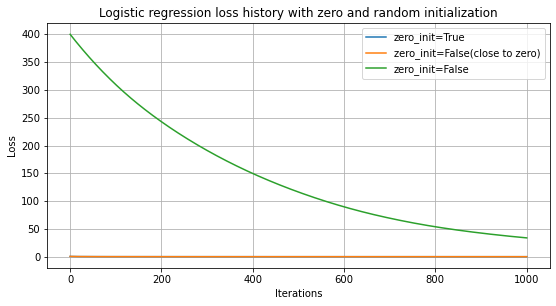

In [29]:
model = CustomLogisticRegressionWithBiggerRandomWeightsRange(zero_init=False)
loss_history.append(model.fit(X_train, y_train))
plot_loss(loss_history, ['True', 'False(close to zero)', 'False'], 'zero_init', title='Logistic regression loss history with zero and random initialization')

Our initial loss became very large compared to the previous random initialization and the model simply does not converge in a given number of iterations (moreover, by the end of 1000 iterations, loss is not even close to the initial loss with zero (and almost-zero random) initialization).  
We will have to increase the learning rate or the number of iterations in this case (or both).  
Thus, too big initial values of weights only slow down the algorithm, which is not very good.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [30]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        pairwise_dist = np.zeros((X.shape[0], Y.shape[0]))
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                pairwise_dist[i][j] = np.sqrt(np.sum((X[i] - Y[j]) ** 2))

        return pairwise_dist
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samples,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        class_weights = dict.fromkeys(self.classes_, 0)
        for index, point in enumerate(y):
            class_weights[point] += weights[index]
        return np.array(list(class_weights.values()))
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
                
            # <your code>

            # sort distances and get indices of k nearest points
            idx_of_k_nearest_neighbors = np.argsort(P, axis=1)[:,:self.n_neighbors]
            
            # get labels of k nearest points
            labels_of_k_nearest_neighbors = self.y[idx_of_k_nearest_neighbors]
            
            # get weights of nearest points
            corresponding_weights = np.take_along_axis(weights_of_points, idx_of_k_nearest_neighbors, axis=1)

            # get class weights
            class_weights = [self.get_class_weights(labels, corresponding_weights[i]) for i, labels in enumerate(labels_of_k_nearest_neighbors)]
            
            # get probabilities
            return np.array([[w / sum(observation) for w in observation] for observation in class_weights])
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        probs = self.predict_proba(X)
        return np.array([self.classes_[i] for i in np.argmax(probs, axis=1)])

In [31]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [32]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [33]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

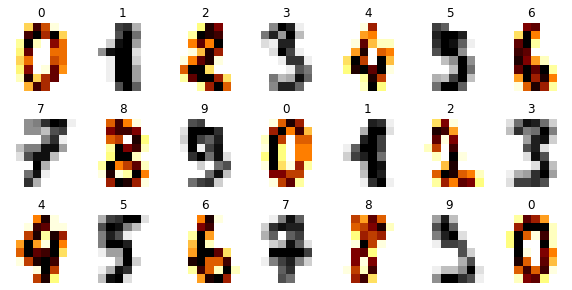

In [34]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [35]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [36]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

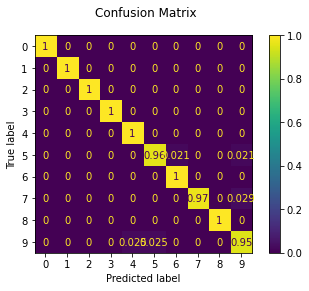

In [37]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [38]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Model sometimes predicts  
6 and 9 instead of 5,   
9 instead of 7,     
3, 4, 5 instead of 9. 

Images have low resolution (8x8 pixels). We only see the outlines of the numbers and some of them are really very similar to each other (position of points in the 8x8 grid is very similar, and sometimes writing a number can vary greatly from case to case and cause a situation where points are possibly closer to some other group of points/digits).  
For example, the first number 5 in picture above really looks like 9.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

Number of neighbors = 1


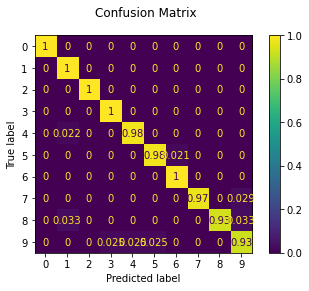

Number of neighbors = 3


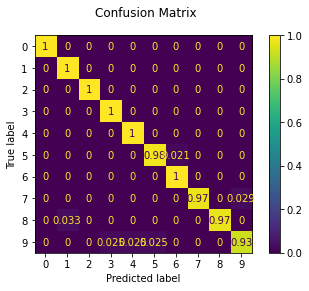

Number of neighbors = 5


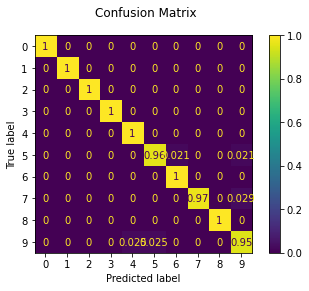

Number of neighbors = 7


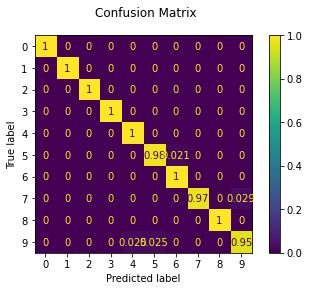

Number of neighbors = 9


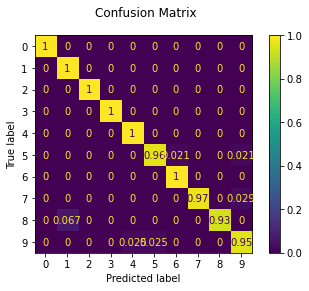

Number of neighbors = 11


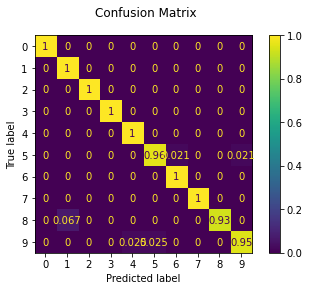

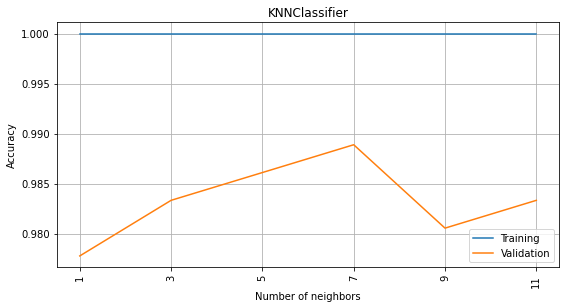

,train_accuracy,test_accuracy
1,1.0,0.977778
3,1.0,0.983333
5,1.0,0.986111
7,1.0,0.988889
9,1.0,0.980556
11,1.0,0.983333


In [39]:
N_NEIGHBORS = [1,3,5,7,9,11]
train_accuracy = []
test_accuracy = []
for n_neighbors in N_NEIGHBORS:
    print(f'Number of neighbors = {n_neighbors}')
    model = CustomKNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

plot_fitting_graph(N_NEIGHBORS, train_accuracy, test_accuracy, xlabel='Number of neighbors', ylabel='Accuracy', title='KNNClassifier')
pd.DataFrame({
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy
}, index=N_NEIGHBORS)

We get the best test accuracy with n = 7. It increases from 1 to 7 and decreases after 7.  
When number of neighbors is too small, it may be that nearest neigbors will be outliers and the model will incorrectly determine the class. If number of neighbors is too high model will take into consideration points that are closer to other groups and missclassification will occure.  

Actually, differences in test accuracy are not so significant. I think this happens because groups of numbers are quite well separable from each other and even when defining a class by only one nearest neighbor, this neighbor will most likely belong to the correct group. Same can be said about the relatively large K(11). Since the groups are well separable, the nearest neighbors will belong to the correct group.  

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

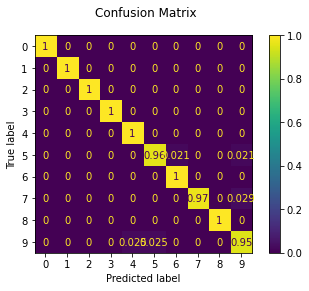

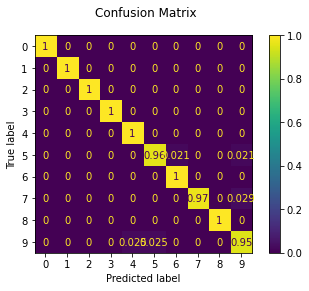

,train_accuracy,test_accuracy
uniform,0.989562,0.986111
distance,1.000000,0.986111


In [40]:
weights = ['uniform', 'distance']
train_accuracy = []
test_accuracy = []
for w in weights:
    model = CustomKNeighborsClassifier(n_neighbors=5, weights=w)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

#plot_fitting_graph(weights, train_accuracy, test_accuracy, xlabel='Weight function', ylabel='Accuracy', title='KNNClassifier')
pd.DataFrame({
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy
}, index=weights)

We see that train accuracy is slightly higher when points are weighted by their distance. With uniform weights model doesn't take into account the distance between the new data point and its k nearest neighbors. They all have equal influence, model doesn't give more weight to the points which are nearby and less weight to the points which are farther away and when there is a case with 'confusing' numbers model can predict the incorrect class.  
But there is no any changes in validation error. Argumentation is the same as in previous task: our dataset is not the best example for exploration how different parameters influnce the model quality because groups of numbers are well separable.  

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

I don't think that simply replasing Euclidean ditance with another one (Manhattan or Minkowski as a generalization of the Euclidean or Manhattan distance) will have any effect on predictions, because we already have pretty good quality (actually, I tried to redefine our custom knn class with Manhattan distance and, indeed, nothing changed).  

In our task we compared images as a (64,1) vectors of numbers, but more complicated methods as detection of important features of an object (appearance of group of pixels in specific locations) may lead to better results.  

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Recommendation systems are common use case for KNN. For example, recommend a movie to a user based on movies that are wathed by 'similar' users (they have watched the same movies and rated them equally). Euclidean distance between users is suitable distance measurement function.

I know that in the tasks of text analysis and text/document classification, the so-called **cosine similarity** is often used.
Cosine distance is used to calculate the similarity of two vectors. It is not a standard distance measure, but still can be used to represent distance in a broad sense. Cosine looks at the angle between vectors and doesn't take into account their magnitudes.  
Example:  
Working with text data represented by word counts. We could assume that when a word (e.g. science) occurs more frequent in document 1 than it does in document 2, that document 1 is more related to the topic of science. However, it could also be the case that we are working with documents of uneven lengths (Wikipedia articles for example). Then, science probably occurred more in document 1 just because it was way longer than document 2. Cosine similarity corrects for this.  

Source article: https://cmry.github.io/notes/euclidean-v-cosine

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [41]:
PATH = "./data/"

In [42]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [43]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [44]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [45]:
pd.DataFrame({
    'count': data['Sex'].value_counts(),
    'frequency(%)': (data['Sex'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
male,56114,56.114
female,43886,43.886


In [46]:
pd.DataFrame({
    'count': data['Survived'].value_counts(),
    'frequency(%)': (data['Survived'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
0,57226,57.226
1,42774,42.774


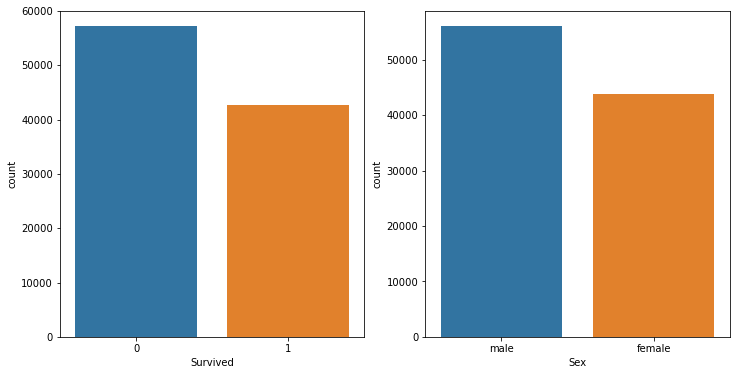

In [47]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=data, x='Sex', ax=axes[1])
sns.countplot(data=data, x='Survived', ax=axes[0])
plt.show()

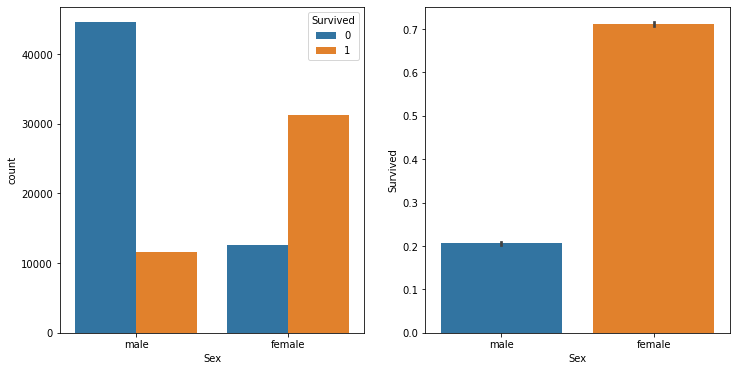

In [48]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=data, x='Sex', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='Sex', y='Survived', ax=axes[1])
plt.show()

In [49]:
print(f"Percentage of survived women: {data.groupby(['Sex'])['Survived'].value_counts()['female'][1] / data['Sex'].value_counts()['female'] * 100: .2f}%")
print(f"Percentage of survived men: {data.groupby(['Sex'])['Survived'].value_counts()['male'][1] / data['Sex'].value_counts()['male'] * 100: .2f}%")

Percentage of survived women:  71.15%
Percentage of survived men:  20.58%


Dataset contains ≈44% of females and ≈56% of males.  
≈43% of passengers survived, while ≈57% didn't.  
Sex is a very strong predictor of survival (≈70% of females survived while only ≈20% of males did).

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

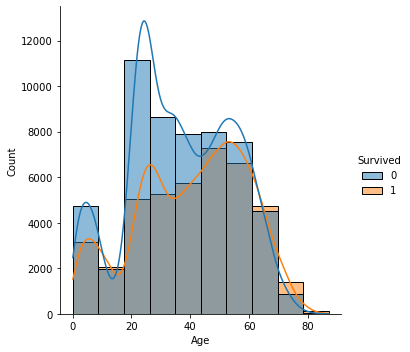

In [50]:
sns.displot(data=data, x='Age', hue='Survived', kde=True, bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

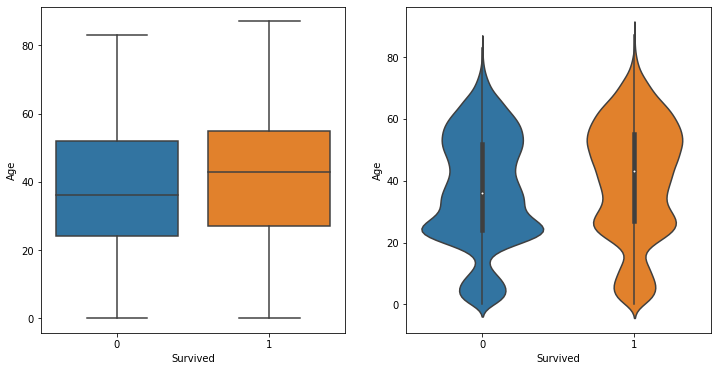

In [51]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(data=data, x='Survived', y='Age', ax=axes[0])
sns.violinplot(data=data, x='Survived', y='Age', ax=axes[1])
plt.show()

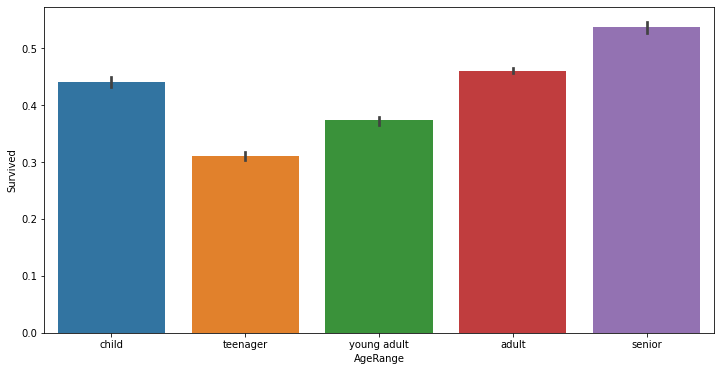

In [52]:
# Divide Age into 5 bins
bins = [0, 14, 25, 35, 60, np.inf]
labels = ['child', 'teenager', 'young adult', 'adult', 'senior']
data['AgeRange'] = pd.cut(data["Age"], bins, labels=labels)

plt.figure(figsize=(12,6))
sns.barplot(data=data, x ='AgeRange', y ='Survived')
plt.show()

In [53]:
pd.DataFrame({
    'Count': data['AgeRange'].value_counts(),
    'Frequency(%)': (data['AgeRange'].value_counts() / data.shape[0]) * 100
})

,Count,Frequency(%)
adult,41536,41.536
young adult,17762,17.762
teenager,14888,14.888
senior,11671,11.671
child,10851,10.851


In [54]:
data.groupby(by=['Survived'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


Mean age ≈ 40, median age = 43 for survived passengers.  
Mean age ≈ 36, median age = 36 for deceased passengers.   

Children under the age of 15 have a better chance of survival than the group aged 14-25 years. After 25, the chances of survival increase with age. Olderly people (60+) had the highest chance of survival. Maybe because they were physically stronger or belonged to higher Pclass (which is a strong predictor of survival too, we will explore it next).

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

**Pclass:**

In [55]:
pd.DataFrame({
    'count': data['Pclass'].value_counts(),
    'frequency(%)': (data['Pclass'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
3,41006,41.006
1,30315,30.315
2,28679,28.679


**Embarked:**

In [56]:
pd.DataFrame({
    'count': data['Embarked'].value_counts(),
    'frequency(%)': (data['Embarked'].value_counts() / data.shape[0]) * 100
})

,count,frequency(%)
S,72139,72.139
C,22187,22.187
Q,5424,5.424


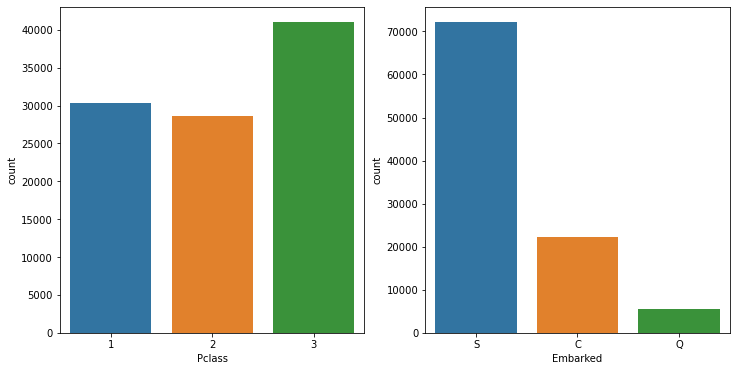

In [57]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=data, x='Pclass', ax=axes[0])
sns.countplot(data=data, x='Embarked', ax=axes[1])
plt.show()

**Pclass x Survived**:

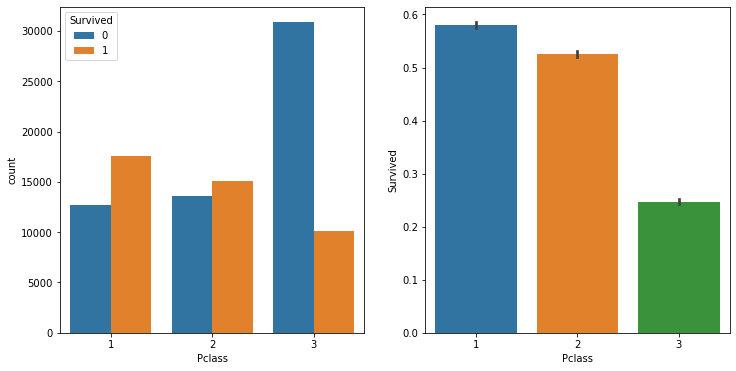

In [58]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=data, x='Pclass', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='Pclass', y='Survived', ax=axes[1])
plt.show()

**Embarked x Survived:**

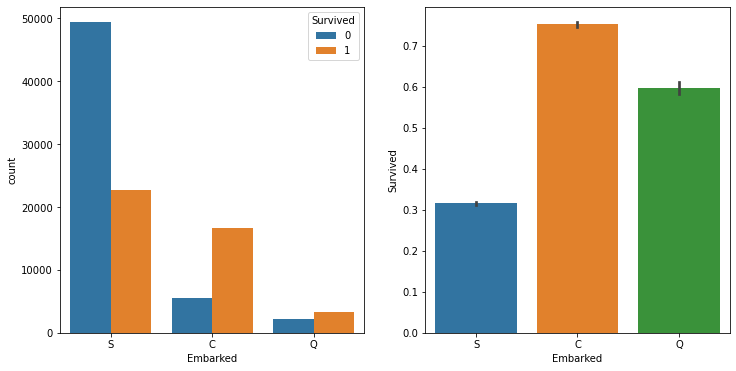

In [59]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=data, x='Embarked', hue='Survived', ax=axes[0])
sns.barplot(data=data, x='Embarked', y='Survived', ax=axes[1])
plt.show()

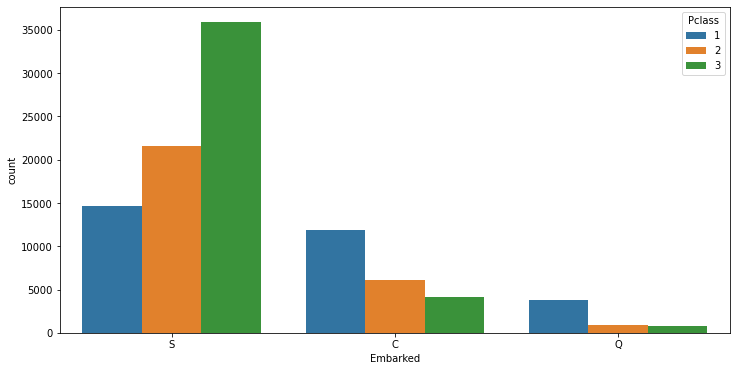

In [60]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Embarked', hue='Pclass')
plt.show()

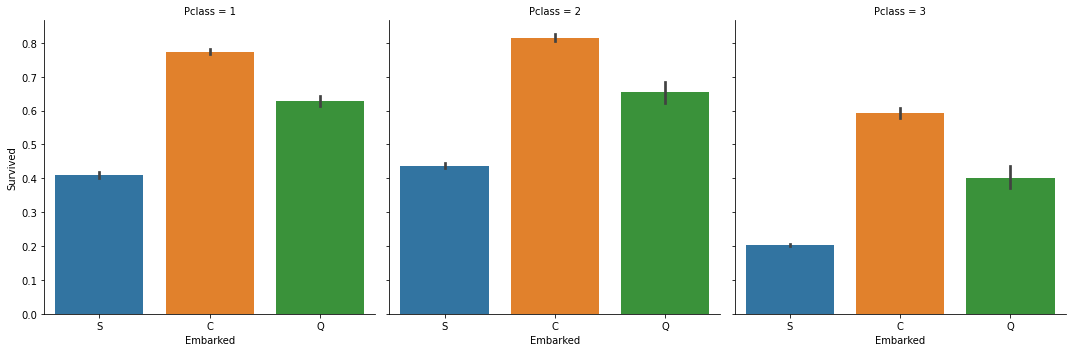

In [61]:
sns.catplot(data=data, x='Embarked', y='Survived', col='Pclass', kind='bar')
plt.show()

Most of passengers belonged to 3-class.
Majority of passengers embarked in Southhampton and only few of them embarked in Queenstown.  
Both variables are good predictors of survival:  
1- and 2-class passengers had advantage. 1 class is 'safest' one.  
Passengers embarked from 'C' and 'Q' ports had advantage. C port is 'safest' one.  
Most of the passengers from port S are 3-class passengers.

Most of the passengers from ports C and Q are 1- and 2-class passengers. Thus, port of embarkation strongly associated with class.  
Ports C and Q give a survival advantage for passengers of all three classes. But the survival rate for 3-class is generally lower than for 1- and 2-class, regardless of the port.  
The chance of survival is higher for 1- and 2-class from C and Q ports.  

If you are curious, you can refer to [my previous analysis](https://github.com/Bayramova/_rs_school/blob/main/titanic_eda.ipynb) for more details.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [62]:
pd.DataFrame({
    'Missing': data.isna().sum(),
    'Missing(%)': (data.isna().sum() / data.shape[0]) * 100
}).sort_values(by='Missing', ascending=False)

,Missing,Missing(%)
Cabin,67866,67.866
Ticket,4623,4.623
Age,3292,3.292
AgeRange,3292,3.292
Embarked,250,0.250
Fare,134,0.134
Survived,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

- **Cabin** column makes most of the missing values. In my previous analysis I concluded that missing values actually means no cabin, which can be explained with cheaper fare and lower class. Probably Cabin column itself can be dropped because its values are just strings and take a lot of unique values, which don't say anything useful. Instead we can create new binary feature HasCabin and assign 0 to all missing Cabin values. But we could miss some important information (cabin deck), which can contribute something to prediction. I will try different approaches later.
- **Ticket** values could have some effect in real Titanic dataset, but in our dataset it would be hard to interpret them. In my previous analysis I showed that passengers with missing ticket value had slightly bigger chances of survival (maybe they belonged to ship crew and had some advantages). So, Ticket column itself can be dropped because its values are just strings and take a lot of unique values, which don't say anything useful. Instead we can create new binary feature HasTicket and assign 0 to all missing Ticket values. Or maybe we can just drop this column without any consequences. I will try different approaches later.
- **Age** values can be simply filled with mean or meadian value, but probably there are more accurate ways to fill them. For example, they can be filled using nearest neighbor(s) imputation or we can try to find out Age relationships with other features and fill missing values with mean/median value in a corresponing Pclass/Sex/etc. It will give us more accurate information.  
- **Embarked** has only 0.25% of missing fields, thus, we can simply fill it with most frequent value 'S' (72% of passengers embarked from S)
- I found out in my previous analysis that **Fare** tends to be higher for higher classes. Pclass values are presented for all passengers, thus, we can fill missing Fare values with mean/median Fare value in a corresponding Pclass.

**AgeRange is a feature which was derived from Age, that's why they have the same amount of missing values. I don't know yet which one I will use in my models

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Let's fill missing Age and Fare values with mean, missing Embarked with mode and create binary variables HasCabin and HasTicket instead initial ones.  
Then we will encode categorical variables Sex, Pclass, Embarked.  
We will not consider Name variable at all.

In [63]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    data_copy['Age'].fillna(data_copy['Age'].mean(), inplace=True)
    data_copy['Fare'].fillna(data_copy['Fare'].mean(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['HasCabin'] = data_copy['Cabin'].fillna(0)
    data_copy['HasCabin'] = data_copy['HasCabin'].apply(lambda x: 0 if x == 0 else 1)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['Age',  'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'HasCabin', 'HasTicket']
    cat_cols = ['Sex', 'Pclass', 'Embarked',]
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

In [64]:
X = prepare(data)
y = data['Survived']

In [65]:
logreg = LogisticRegression()
knn_distance = KNeighborsClassifier(weights='distance')
knn_uniform = KNeighborsClassifier(weights='uniform')

cv_results_lr = cross_validate(logreg, X, y, scoring='accuracy')
print(f"logreg: {cv_results_lr['test_score'].mean()}")

cv_results_knn_d = cross_validate(knn_distance, X, y, scoring='accuracy')
print(f"knn_distance: {cv_results_knn_d['test_score'].mean()}")

cv_results_knn_u = cross_validate(knn_uniform, X, y, scoring='accuracy')
print(f"knn_uniform: {cv_results_knn_u['test_score'].mean()}")

logreg: 0.7704
knn_distance: 0.72177
knn_uniform: 0.74451


Logistic Regression show the best accuracy on test.   
Knn takes quite a long time to train.  
I will use only Logistic Regression in future.  
Let's use it to predict labels and make our first submission:

In [66]:
logreg.fit(X, y)
preds = logreg.predict(prepare(test_data))

In [67]:
pd.DataFrame({
    'PassengerId': test_data.index,
    'Survived': preds
}).to_csv(os.path.join(PATH, 'titanic', 'submission_initial.csv'), index=False)

Private score: 0.77604  
Public score: 0.77589

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Let's see what we can do with Age variable. Let's try to fill missing values with median instead of mean:

In [68]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    data_copy['Age'].fillna(data_copy['Age'].median(), inplace=True)
    data_copy['Fare'].fillna(data_copy['Fare'].mean(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['HasCabin'] = data_copy['Cabin'].fillna(0)
    data_copy['HasCabin'] = data_copy['HasCabin'].apply(lambda x: 0 if x == 0 else 1)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['Age',  'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'HasCabin', 'HasTicket']
    cat_cols = ['Sex', 'Pclass', 'Embarked',]
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

X = prepare(data)
logreg = LogisticRegression()
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.7704


Nothing changed. Let's fill it with mean/median value in corresponding Pclass:

In [69]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    data_copy['Age'] = data_copy.groupby(by=['Pclass'])['Age'].transform(lambda group: group.fillna(group.median()))
    data_copy['Fare'].fillna(data_copy['Fare'].mean(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['HasCabin'] = data_copy['Cabin'].fillna(0)
    data_copy['HasCabin'] = data_copy['HasCabin'].apply(lambda x: 0 if x == 0 else 1)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['Age',  'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'HasCabin', 'HasTicket']
    cat_cols = ['Sex', 'Pclass', 'Embarked',]
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

X = prepare(data)
logreg = LogisticRegression()
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.77041


Now let's use AgeRange variable instead of Age:

In [70]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    data_copy['Age'] = data_copy.groupby(by=['Pclass'])['Age'].transform(lambda group: group.fillna(group.median()))
    bins = [0, 14, 25, 35, 60, np.inf]
    labels = ['child', 'teenager', 'young adult', 'adult', 'senior']
    data_copy['AgeRange'] = pd.cut(data_copy["Age"], bins, labels=labels)

    data_copy['Fare'].fillna(data_copy['Fare'].mean(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['HasCabin'] = data_copy['Cabin'].fillna(0)
    data_copy['HasCabin'] = data_copy['HasCabin'].apply(lambda x: 0 if x == 0 else 1)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['AgeRange',  'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'HasCabin', 'HasTicket']
    cat_cols = ['AgeRange', 'Sex', 'Pclass', 'Embarked',]
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

X = prepare(data)
logreg = LogisticRegression()
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.77037


Let's use bigger Age bins:

In [71]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    data_copy['Age'] = data_copy.groupby(by=['Pclass'])['Age'].transform(lambda group: group.fillna(group.median()))
    bins = [0, 20, 40, 60, np.inf]
    labels = ['teenager', 'young adult', 'adult', 'senior']
    data_copy['AgeRange'] = pd.cut(data_copy["Age"], bins, labels=labels)

    data_copy['Fare'].fillna(data_copy['Fare'].mean(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['HasCabin'] = data_copy['Cabin'].fillna(0)
    data_copy['HasCabin'] = data_copy['HasCabin'].apply(lambda x: 0 if x == 0 else 1)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['AgeRange',  'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'HasCabin', 'HasTicket']
    cat_cols = ['AgeRange', 'Sex', 'Pclass', 'Embarked',]
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

X = prepare(data)
logreg = LogisticRegression()
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.77064


Accuracy got better. Now let's try to use 'NA' value for missing age instead of median:

In [72]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    bins = [0, 20, 40, 60, np.inf]
    labels = ['teenager', 'young adult', 'adult', 'senior']
    data_copy['AgeRange'] = pd.cut(data_copy["Age"], bins, labels=labels)
    data_copy = data_copy.astype({'AgeRange': 'object'})
    data_copy['AgeRange'].fillna('NA', inplace=True)

    data_copy['Fare'].fillna(data_copy['Fare'].mean(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['HasCabin'] = data_copy['Cabin'].fillna(0)
    data_copy['HasCabin'] = data_copy['HasCabin'].apply(lambda x: 0 if x == 0 else 1)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['AgeRange',  'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'HasCabin', 'HasTicket']
    cat_cols = ['AgeRange', 'Sex', 'Pclass', 'Embarked',]
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

X = prepare(data)
logreg = LogisticRegression()
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.77063


Now let's apply the same ideas to Fare:

In [73]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    data_copy['Age'] = data_copy.groupby(by=['Pclass'])['Age'].transform(lambda group: group.fillna(group.median()))
    bins = [0, 20, 40, 60, np.inf]
    labels = ['teenager', 'young adult', 'adult', 'senior']
    data_copy['AgeRange'] = pd.cut(data_copy["Age"], bins, labels=labels)
    data_copy = data_copy.astype({'AgeRange': 'object'})
    data_copy['AgeRange'].fillna('NA', inplace=True)

    data_copy['Fare'].fillna(data_copy['Fare'].median(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['HasCabin'] = data_copy['Cabin'].fillna(0)
    data_copy['HasCabin'] = data_copy['HasCabin'].apply(lambda x: 0 if x == 0 else 1)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['AgeRange', 'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'HasCabin', 'HasTicket']
    cat_cols = ['AgeRange', 'Sex', 'Pclass', 'Embarked',]
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

X = prepare(data)
logreg = LogisticRegression()
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.77064


I tried different approaches and got best accuracy with what is coded above.  

I will change the way I handle **Cabin** column. Instead of creating binary HasCabin column I will extract the deck (first letter) from cabin values and fill missing values with 'NA':

In [74]:
def prepare(data):
    data_copy = data.copy()

    data_copy['Age'].fillna(data_copy['Age'].median(), inplace=True)
    data_copy['Fare'].fillna(data_copy['Fare'].median(), inplace=True)

    data_copy['Embarked'].fillna('S', inplace=True)

    data_copy['Cabin'].fillna('NA', inplace=True)
    data_copy['Cabin'] = data_copy['Cabin'].apply(lambda x: x[0] if x != 'NA' else x)

    data_copy['HasTicket'] = data_copy['Ticket'].fillna(0)
    data_copy['HasTicket'] = data_copy['HasTicket'].apply(lambda x: 0 if x == 0 else 1)

    # encode categorical variables
    features = ['Age',  'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass',  'Embarked', 'Cabin', 'HasTicket']
    cat_cols = ['Sex', 'Pclass', 'Embarked', 'Cabin']
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_scaled, columns=columns)

X = prepare(data)
logreg = LogisticRegression()
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.7763699999999999


I tried a lot of different ways of handling features (A LOT of different ways) and decided not to save them here to avoid mess.  
Eventually, I get the best public score with following approach:  
- fill missing Age and Fare values with median value in corresponding Pclass
- create new binary feature IsAlone based on family size (SibSp + Parch), drop SibSp and Parch
- extract first letter(deck) from Cabin and fill missing values with 'NA'
- split Ticket value, extract fisrt split, fill missing value with 'NA'
- map Sex to 0 and 1
- create new artificial feature from Age and Pclass, drop them
- apply one hot encoding to Embarked, Cabin and Ticket

In [75]:
def prepare(data):
    data_copy = data.copy()
    
    # handle missing values
    data_copy['Age'] = data_copy.groupby(by=['Pclass'])['Age'].transform(lambda group: group.fillna(group.median()))
    data_copy['Fare'] = data_copy.groupby(by=['Pclass'])['Fare'].transform(lambda group: group.fillna(group.median()))
    data_copy['Embarked'].fillna('S', inplace=True)

    # create new feature IsAlone
    data_copy['IsAlone'] = data_copy['SibSp'] + data_copy['Parch']
    data_copy['IsAlone'] = data_copy['IsAlone'].apply(lambda x: 1 if x == 0 else 0)

    # extract first letter (deck) from Cabin and fill missing values with 'NA'
    data_copy['Cabin'].fillna('NA', inplace=True)
    data_copy['Cabin'] = data_copy['Cabin'].apply(lambda x: x[0] if x != 'NA' else x)

    # split Ticket value, extract fisrt split, fill missing value with 'NA'
    data_copy['Ticket'] = data_copy['Ticket'].fillna('NA').apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'NA')

    # map Sex 
    data_copy['Sex'] = data_copy['Sex'].map({
        'male': 0,
        'female': 1
    })

    # create artificial feature from Age and Pclass
    data_copy['Age*Class'] = data_copy['Age'] * data_copy['Pclass']
    
    # encode categorical variables
    features = ['Fare', 'Sex',  'Embarked', 'Cabin', 'IsAlone', 'Ticket', 'Age*Class']
    cat_cols = ['Embarked', 'Cabin', 'Ticket']
    data_copy = pd.get_dummies(data_copy[features], columns=cat_cols)
    columns = data_copy.columns
    
    # scale the data
    scaler = StandardScaler()
    data_copy = scaler.fit_transform(data_copy)
    
    return pd.DataFrame(data_copy, columns=columns)

In [76]:
X = prepare(data)
logreg = LogisticRegression(random_state=0)
cv_results = cross_validate(logreg, X, y, scoring='accuracy')
print(f"accuracy: {cv_results['test_score'].mean()}")

accuracy: 0.77665


In [77]:
logreg.fit(X, y)
preds = logreg.predict(prepare(test_data))
pd.DataFrame({
    'PassengerId': test_data.index,
    'Survived': preds
}).to_csv(os.path.join(PATH, 'titanic', 'submission.csv'), index=False)

**Public score**: 0.80047  
You can find sumbission file in ./data/titanic folder
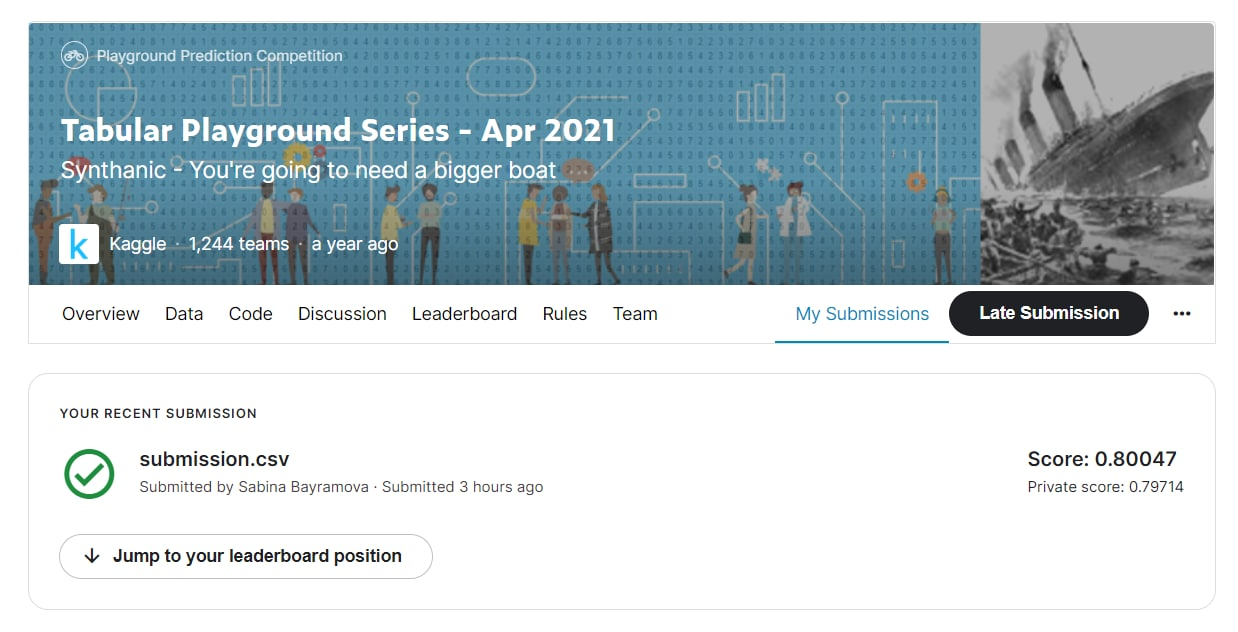

I tried to use GridSearchCV, but it didn't improve my public score:

In [78]:
from sklearn.model_selection import GridSearchCV

grid = {
    'C': [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.1, 1], 
    'penalty': ['none', "l1", "l2", 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, scoring='accuracy')
logreg_cv.fit(X, y)

print(f'best parameters: {logreg_cv.best_params_}')
print(f'accuracy: {logreg_cv.best_score_}')

best parameters: {'C': 0.005, 'penalty': 'l1', 'solver': 'saga'}
accuracy: 0.7771399999999999


In [79]:
# logreg_cv.best_estimator_.fit(X, y)
# preds = logreg_cv.best_estimator_.predict(prepare(test_data))

# pd.DataFrame({
#     'PassengerId': test_data.index,
#     'Survived': preds
# }).to_csv(os.path.join(PATH, 'titanic', 'submission.csv'), index=False)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.